In [1]:
import pathlib

# from matplotlib.patches import Circle
from typing import Dict, List, Tuple

import jupedsim as jps
import matplotlib.pyplot as plt
import numpy as np
import pedpy
import shapely
from shapely import Polygon

%matplotlib inline

/var/folders/68/h1h7hy7n4bq5w69q7qdrrtvc0000gn/T/ipykernel_12936/3822242443.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Simulating Single-File Movement

This notebook can be directly downloaded {download}`here <./single-file.ipynb>` to run it locally.

Pedestrian dynamics often focuses on the relationship between two key variables: density and either flow or velocity. The relationship is often visualized in what's termed as the fundamental diagram. By quantifying the capacity of pedestrian facilities, it serves as an essential tool for evaluating escape routes in emergencies and determining the effectiveness of various pedestrian movement models when depicting pedestrian streams.

A fundamental question arises: how does one investigate the intricacies of the fundamental diagram without the interference of external factors? 

Single-file movement presents the simplest possible system in pedestrian dynamics. It is envisioned as the unidirectional motion of individuals moving along a straight line, thereby considerably reducing the degrees of freedom. In essence, by stripping down the system to this basic representation, it limits the external factors that might affect the outcomes. As a result, any observations or patterns detected can be attributed with higher confidence to the direct interplay between density and flow, providing a clearer understanding of the fundamental diagram.

In this tutorial, we'll simulate with JuPedSim a simplified geometry with closed boundary conditions acording to [Paetzke](https://doi.org/10.3390/app13095450).

![](./demo-data/single-file/single-file.png)

In [2]:
def generate_oval_shape_points(
    num_points: int,
    length: float = 2.3,
    radius: float = 1.65,
    start: Tuple[float, float] = (0.0, 0.0),
    dx: float = 0.2,
    threshold: float = 0.5,
):
    """Generate points on a closed setup with two segments and two half circles."""
    points = [start]
    selected_points = [start]
    last_selected = start  # keep track of the last selected point

    # Define the points' generating functions
    def dist(p1, p2):
        return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

    # Calculate dphi based on the dx and radius
    dphi = dx / radius

    center2 = (start[0] + length, start[1] + radius)
    center1 = (start[0], start[1] + radius)

    npoint_on_segment = int(length / dx)

    # first segment
    for i in range(1, npoint_on_segment + 1):
        tmp_point = (start[0] + i * dx, start[1])
        points.append(tmp_point)
        if dist(tmp_point, last_selected) >= threshold:
            selected_points.append(tmp_point)
            last_selected = tmp_point

    # first half circle
    for phi in np.arange(-np.pi / 2, np.pi / 2, dphi):
        x = center2[0] + radius * np.cos(phi)
        y = center2[1] + radius * np.sin(phi)
        tmp_point = (x, y)
        points.append(tmp_point)
        if dist(tmp_point, last_selected) >= threshold:
            selected_points.append(tmp_point)
            last_selected = tmp_point

    # second segment
    for i in range(1, npoint_on_segment + 1):
        tmp_point = (
            start[0] + (npoint_on_segment + 1) * dx - i * dx,
            start[1] + 2 * radius,
        )
        points.append(tmp_point)
        if dist(tmp_point, last_selected) >= threshold:
            selected_points.append(tmp_point)
            last_selected = tmp_point

    # second half circle
    for phi in np.arange(np.pi / 2, 3 * np.pi / 2 - dphi, dphi):
        x = center1[0] + radius * np.cos(phi)
        y = center1[1] + radius * np.sin(phi)
        tmp_point = (x, y)
        points.append(tmp_point)
        if dist(tmp_point, last_selected) >= threshold:
            selected_points.append(tmp_point)
            last_selected = tmp_point

    if dist(selected_points[-1], start) < threshold:
        selected_points.pop()
    if num_points > len(selected_points):
        print(f"warning: {num_points} > Allowed: {len(selected_points)}")

    selected_points = selected_points[:num_points]
    return points, selected_points

In [3]:
_, exterior = generate_oval_shape_points(
    48, radius=1.65 + 0.4, start=(0, -0.4), threshold=0.2
)
_, interior = generate_oval_shape_points(
    35, radius=1.65 - 0.4, start=(0, 0.4), threshold=0.2
)
walkable_area = pedpy.WalkableArea(
    shapely.difference(Polygon(exterior), Polygon(interior))
)

In [4]:
def find_nearest_clockwise_waypoint(position, all_points, waypoints):
    idx = all_points.index(position)
    while True:
        idx = (idx + 1) % len(all_points)
        if all_points[idx] in waypoints:
            return all_points[idx]

## Scenario Overview

Let's begin by positioning $N$ agents along the central path within our specified geometry. This particular geometry presents an interesting challenge; though our goal is to simulate a movement akin to 1D, where agents traverse a straight line, the line here is bent.

We will set up the waypoints and agent positions based on the circuit illustrated by the dashed line in the preceding figure.

Each agent will be assigned its initial waypoint to aim for.


In [5]:
def distribute_agents_and_waypoints(total_agents: int):
    all_waypoints, positions = generate_oval_shape_points(
        num_points=total_agents
    )
    first_waypoints = []
    for position in positions:
        first_waypoints.append(
            find_nearest_clockwise_waypoint(
                position, all_waypoints, all_waypoints
            )
        )

    return all_waypoints, first_waypoints, positions

In [6]:
def plot_points_and_polygons(
    all_waypoints, choosen_waypoints, exterior, interior, positions
):
    __file__, ax = plt.subplots(ncols=1, nrows=1)
    ax.set_aspect("equal")
    x_exterior, y_exterior = Polygon(exterior).exterior.xy
    plt.plot(x_exterior, y_exterior, "-k", label="exterior")
    plt.fill(x_exterior, y_exterior, alpha=0.3)

    x_interior, y_interior = Polygon(interior).exterior.xy
    plt.plot(x_interior, y_interior, "--k", label="interior")
    plt.fill(x_interior, y_interior, alpha=0.3)

    x_awp, y_awp = Polygon(all_waypoints).exterior.xy
    plt.plot(x_awp, y_awp, "-r")
    plt.fill(x_awp, y_awp, alpha=0.3)
    plt.scatter(*zip(*all_waypoints), marker=".", label="waypoints")

    x_agents, y_agents = Polygon(positions).exterior.xy

    plt.plot(x_agents, y_agents, "ob", ms=8, label="agents")

    x_wp, y_wp = Polygon(choosen_waypoints).exterior.xy

    plt.plot(x_wp, y_wp, "xk", ms=5, label="first goals")

    plt.legend()
    plt.title(f"N={len(positions)}")
    plt.show()

In [7]:
def compute_unit_vector(new_pos, wp):
    dx = wp[0] - new_pos[0]
    dy = wp[1] - new_pos[1]

    magnitude = (dx**2 + dy**2) ** 0.5

    if magnitude == 0:
        return (0, 0)

    ux = dx / magnitude
    uy = dy / magnitude

    return (ux, uy)

## Defining the Journey

For our simulation, we're aiming for movement within a closed system. To achieve this, we'll establish a cyclical transition between waypoints, allowing agents to seamlessly move from one waypoint to the next. Given this structure, agents are confined within the system, eliminating the need for exit points.

While the starting orientation of our agents might not play a pivotal role, we'll still configure it for precision. This means that, from the outset, each agent will be oriented towards its initially selected waypoint.

In [8]:
def init_waypoints(
    simulation, all_waypoints: List[Tuple[float, float]]
) -> Dict[Tuple[float, float], id]:
    waypoint_ids = []
    waypoints: Dict[Tuple[float, float], id] = {}
    distance = 0.1
    for waypoint in all_waypoints:
        wp_id = simulation.add_waypoint_stage(waypoint, distance)
        waypoint_ids.append(wp_id)
        waypoints[waypoint] = wp_id

    return waypoints

In [9]:
def init_journey(
    simulation: jps.Simulation, waypoints: Dict[Tuple[float, float], id]
) -> int:
    waypoint_ids = list(waypoints.values())
    journey = jps.JourneyDescription(waypoint_ids)
    # create a circular transition from wp to next wp
    for idx, waypoint in enumerate(waypoint_ids):
        next_waypoint = (
            waypoint_ids[0]
            if idx == len(waypoint_ids) - 1
            else waypoint_ids[idx + 1]
        )
        journey.set_transition_for_stage(
            waypoint, jps.Transition.create_fixed_transition(next_waypoint)
        )

    journey_id = simulation.add_journey(journey)
    return journey_id

In [10]:
def add_model_to_simulation(
    simulation: jps.Simulation,
    positions,
    choosen_waypoints,
    waypoints: Dict[Tuple[float, float], id],
    journey_id: int,
) -> None:
    agent_parameters = jps.CollisionFreeSpeedModelAgentParameters()
    agent_parameters.journey_id = journey_id
    for wp, new_pos in zip(choosen_waypoints, positions):
        agent_parameters.position = new_pos
        agent_parameters.stage_id = waypoints[wp]
        simulation.add_agent(agent_parameters)

## Executing the Simulation

Now, we'll proceed to run our simulation up to a predefined maximum iteration count. This approach lets the internal dynamics stabilize, potentially reaching a steady state. However, it's worth noting that certain dynamics, like stop-and-go waves, might prevent the system from settling into such a state.

In [11]:
def run_simulation(total_agents: int, number_iterations: int = 2000):
    (
        all_waypoints,
        first_waypoints,
        positions,
    ) = distribute_agents_and_waypoints(total_agents)
    plot_points_and_polygons(
        all_waypoints, first_waypoints, exterior, interior, positions
    )
    trajectory_file = f"single-file-{total_agents}.sqlite"
    simulation = jps.Simulation(
        dt=0.05,
        model=jps.CollisionFreeSpeedModel(
            strength_neighbor_repulsion=2.6,
            range_neighbor_repulsion=0.1,
            range_geometry_repulsion=0.05,
        ),
        geometry=exterior,
        excluded_areas=interior,
        trajectory_writer=jps.SqliteTrajectoryWriter(
            output_file=pathlib.Path(trajectory_file),
        ),
    )
    waypoints = init_waypoints(simulation, all_waypoints)
    journey_id = init_journey(simulation, waypoints)
    add_model_to_simulation(
        simulation, positions, first_waypoints, waypoints, journey_id
    )

    while simulation.iteration_count() < number_iterations:
        simulation.iterate()

    return trajectory_file

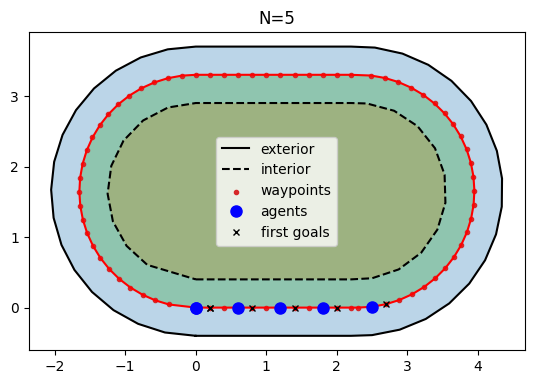

RuntimeError: Point (0.40000000000000036, 3.3) outside accessible area

In [12]:
trajectory_files = [run_simulation(N) for N in [5, 15, 20, 24]]

In [ ]:
from jupedsim.internal.notebook_utils import animate, read_sqlite_file

for trajectory_file in trajectory_files:
    trajectories, walkable_area_sqlite = read_sqlite_file(trajectory_file)
    animate(trajectories, walkable_area, every_nth_frame=5).show()

## Discussion

The behavior of agents closely following a central path can be attributed to the dense distribution of waypoints with a small radius. Essentially, the dense waypoints give agents minimal options for deviation, making them adhere closely to the specified path. This can be advantageous in scenarios where precise path-following is necessary.

However, the observed behavior of stop-and-go waves disappearing over time indicates an imperfection in the model, especially if such dynamics are expected or seen in real-world scenarios that the model aims to emulate. The fading of these waves suggests that the agents stabilize into a flow that doesn't have the intermittent stop-and-go behavior.

Velocity-based models often have this limitation. In such models, agents typically adjust their velocities based on surrounding conditions. Once the initial disturbances (like starting from rest or initial congestions) are overcome, the agents find a sort of "equilibrium" velocity, leading to a smoother flow. This smooth flow may not always accurately represent real-world dynamics, especially in situations with frequent perturbations or inherent unpredictabilities, like human-driven traffic.

## Summary

The model effectively simulates agents that adhere closely to a central path due to the dense distribution of waypoints with small radii. However, the disappearance of stop-and-go waves over time highlights a limitation inherent to velocity-based models. Such models may not be suitable for scenarios where persistent stop-and-go dynamics are expected or required. Future iterations of the model may benefit from incorporating additional factors or behaviors to better simulate such dynamics.

# Download

This notebook can be directly downloaded {download}`here <./single-file.ipynb>` to run it locally.